In [1]:
import pandas as pd
import numpy as np

# 1) Load & clean
df = pd.read_csv('preprocessed_kindle_review.csv').drop(columns=['Unnamed: 0'], errors='ignore')
df = df.head(15).copy()

# (A) Implementation of dependency-based parsing for sentiment

In [2]:
import spacy
from textblob import TextBlob

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")
df = pd.read_csv('preprocessed_kindle_review.csv', nrows=15)
reviews = df['reviewText'].astype(str).tolist()

def extract_aspect_sentiment(text):
    doc = nlp(text)
    aspects = []
    for token in doc:
        if token.pos_ == 'NOUN':
            aspect_phrase = ' '.join([t.text for t in token.subtree])
            # Get sentiment polarity for the phrase
            blob = TextBlob(aspect_phrase)
            sentiment = blob.sentiment.polarity
            if sentiment > 0.1:
                sentiment_label = 'Positive'
            elif sentiment < -0.1:
                sentiment_label = 'Negative'
            else:
                sentiment_label = 'Neutral'
            aspects.append({'aspect': token.lemma_, 'phrase': aspect_phrase, 'sentiment': sentiment_label})
    return aspects

# Apply to first 15 reviews
results = []
for idx, review in enumerate(reviews):
    aspects = extract_aspect_sentiment(review)
    results.append({'review_id': idx, 'aspects': aspects})

# Print results
for r in results:
    print(f"Review {r['review_id']}:")
    for asp in r['aspects']:
        print(f"  Aspect: {asp['aspect']} | Phrase: \"{asp['phrase']}\" | Sentiment: {asp['sentiment']}")
    print('-' * 50)

Review 0:
  Aspect: book | Phrase: "This book" | Sentiment: Neutral
  Aspect: bookmobile | Phrase: "bookmobile" | Sentiment: Neutral
  Aspect: book | Phrase: "the very first bookmobile book I bought when I was in the school book club" | Sentiment: Positive
  Aspect: school | Phrase: "school" | Sentiment: Neutral
  Aspect: book | Phrase: "book" | Sentiment: Neutral
  Aspect: club | Phrase: "the school book club" | Sentiment: Neutral
  Aspect: story | Phrase: "the story" | Sentiment: Neutral
  Aspect: dollar | Phrase: "a dollar" | Sentiment: Neutral
  Aspect: donut | Phrase: "a donut" | Sentiment: Neutral
  Aspect: memory | Phrase: "my memory" | Sentiment: Neutral
  Aspect: book | Phrase: "this book" | Sentiment: Neutral
  Aspect: grade | Phrase: "5th grade" | Sentiment: Neutral
  Aspect: memory | Phrase: "the memories" | Sentiment: Neutral
--------------------------------------------------
Review 1:
  Aspect: description | Phrase: "the description for this book" | Sentiment: Neutral
  A

# (B) Implementation of at least one of unsupervised machine learning algorithms

In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

df = pd.read_csv('preprocessed_kindle_review.csv')

#map ratings to sentiment (1/2 = negative, 4/5 = positive, drop 3)
def map_sentiment(rating):
    if rating in [4, 5]:
        return 1  # positive
    elif rating in [1, 2]:
        return 0  # negative
    else:
        return None

df['sentiment'] = df['rating'].apply(map_sentiment)
df = df.dropna(subset=['sentiment'])

#use only reviewText for input
texts = df['reviewText'].astype(str).tolist()
labels = df['sentiment'].astype(int).tolist()

#tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

dataset = ReviewDataset(inputs, labels)

#split into train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()
eval_result = trainer.evaluate()
print(eval_result)

c:\Users\Muhammad Zafran\.conda\envs\nlpenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4060612916946411, 'eval_runtime': 14.254, 'eval_samples_per_second': 140.311, 'eval_steps_per_second': 17.539, 'epoch': 3.0}


Using DBSCAN Unsupervised Learning Algortihm

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN

#Clustering with DBSCAN
df = pd.read_csv('preprocessed_kindle_review.csv')
reviews = df['reviewText'].astype(str).tolist()

#convert reviews to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X = vectorizer.fit_transform(reviews)

#DBSCAN clustering
dbscan = DBSCAN(eps=0.7, min_samples=2, metric='cosine')
labels = dbscan.fit_predict(X)


for idx, (review, label) in enumerate(zip(reviews, labels)):
    print(f"Review {idx} assigned to Cluster {label}")
    print(f"Text: {review[:120]}...")  #print first 120 characters
    print('')

Review 0 assigned to Cluster 0
Text: This book was the very first bookmobile book I bought when I was in the school book club. I loved the story then and I b...

Review 1 assigned to Cluster 0
Text: When I read the description for this book, I couldn't wait to read it. Once I downloaded it to my Kindle, I found it ext...

Review 2 assigned to Cluster 0
Text: I just had to edit this review. This book is an (I believe I got this right) an updated re-write. Thank god I didn't get...

Review 3 assigned to Cluster 0
Text: I don't normally buy 'mystery' novels because I just don't like them.  However, this time I decided to take a chance and...

Review 4 assigned to Cluster 0
Text: This isn't the kind of book I normally read, although I try not to limit myself to certain genres. Sometimes I find epic...

Review 5 assigned to Cluster 0
Text: I really enjoyed how this story developed.  Its a well-written Sci-fi depicting what happens when an alien race quietly ...

Review 6 assigned to Cluster

Visualisation of DBSCAN cluster

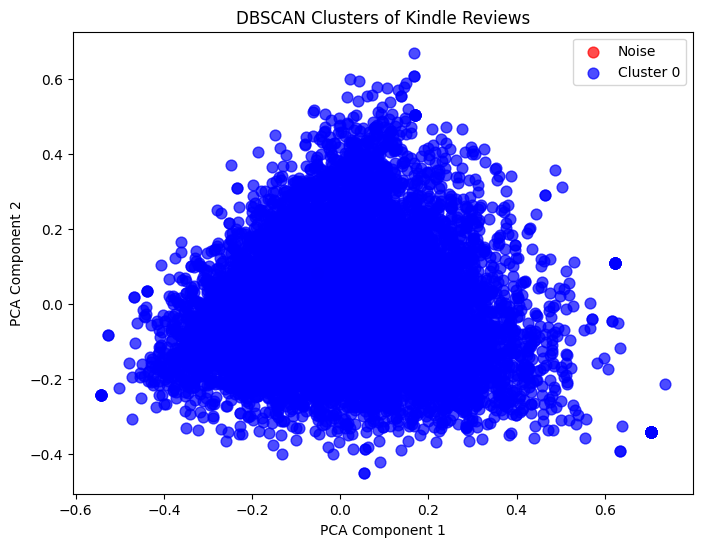

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plot
color_map = {-1: 'red', 0: 'blue'}

plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        c=color_map.get(label, 'gray'),
        label='Noise' if label == -1 else f'Cluster {label}',
        alpha=0.7, s=60
    )

plt.title('DBSCAN Clusters of Kindle Reviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

Kmeans algorithm is also used as an unsupervised learning algorithm

In [6]:
from sklearn.cluster import KMeans


df = pd.read_csv('preprocessed_kindle_review.csv')
reviews = df['reviewText'].astype(str).tolist()

vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X = vectorizer.fit_transform(reviews)

#KMeans clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

#print cluster assignments
for idx, (review, label) in enumerate(zip(reviews, labels)):
    print(f"Review {idx} assigned to Cluster {label}")
    print(f"Text: {review[:120]}...")  #print first 120 characters
    print('')
    


Review 0 assigned to Cluster 2
Text: This book was the very first bookmobile book I bought when I was in the school book club. I loved the story then and I b...

Review 1 assigned to Cluster 2
Text: When I read the description for this book, I couldn't wait to read it. Once I downloaded it to my Kindle, I found it ext...

Review 2 assigned to Cluster 0
Text: I just had to edit this review. This book is an (I believe I got this right) an updated re-write. Thank god I didn't get...

Review 3 assigned to Cluster 0
Text: I don't normally buy 'mystery' novels because I just don't like them.  However, this time I decided to take a chance and...

Review 4 assigned to Cluster 0
Text: This isn't the kind of book I normally read, although I try not to limit myself to certain genres. Sometimes I find epic...

Review 5 assigned to Cluster 1
Text: I really enjoyed how this story developed.  Its a well-written Sci-fi depicting what happens when an alien race quietly ...

Review 6 assigned to Cluster

Kmeans clustering visualisation

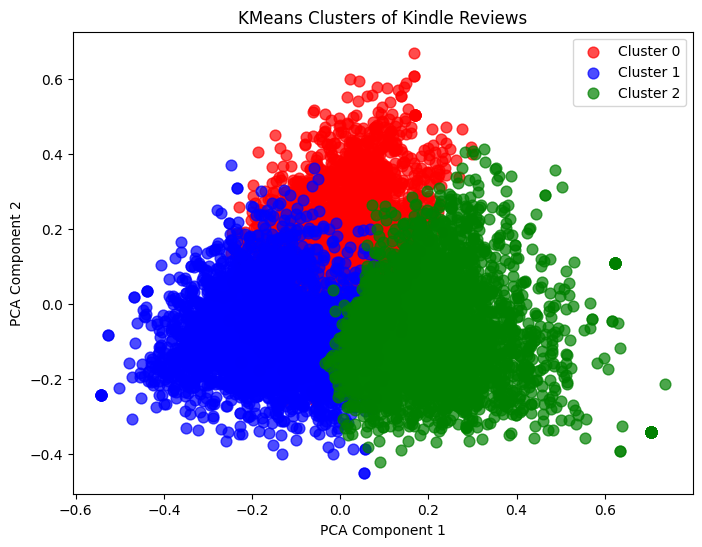

In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(n_clusters):
    mask = labels == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                label=f'Cluster {i}', 
                alpha=0.7, s=60, c=colors[i])

plt.title('KMeans Clusters of Kindle Reviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# (C) Implementation of at least one supervised machine learning algorithms

The logistic regression alrgortithm is used

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load data
df = pd.read_csv('preprocessed_kindle_review.csv')

#map ratings to sentiment 
def map_sentiment(rating):
    if rating in [4, 5]:
        return 1  #positive
    elif rating in [1, 2]:
        return 0  #negative
    else:
        return None

df['sentiment'] = df['rating'].apply(map_sentiment)
df = df.dropna(subset=['sentiment'])

#prepare features and labels
X = df['reviewText'].astype(str)
y = df['sentiment'].astype(int)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#train Logistic Regression
clf = LogisticRegression(max_iter=200)
clf.fit(X_train_vec, y_train)

#predict and evaluate
y_pred = clf.predict(X_test_vec)
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.86      0.83      0.84       829
    positive       0.88      0.91      0.89      1171

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



Supoort Vector Machine is also used

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report


df = pd.read_csv('preprocessed_kindle_review.csv')

def map_sentiment(rating):
    if rating in [4, 5]:
        return 1  #positive
    elif rating in [1, 2]:
        return 0  #negative
    else:
        return None

df['sentiment'] = df['rating'].apply(map_sentiment)
df = df.dropna(subset=['sentiment'])


X = df['reviewText'].astype(str)
y = df['sentiment'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#train SVM
clf = LinearSVC()
clf.fit(X_train_vec, y_train)


y_pred = clf.predict(X_test_vec)
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.85      0.84      0.84       829
    positive       0.89      0.89      0.89      1171

    accuracy                           0.87      2000
   macro avg       0.87      0.86      0.87      2000
weighted avg       0.87      0.87      0.87      2000

